<a href="https://colab.research.google.com/github/DerejeCShenkut/gsp-project/blob/main/GeoAI_cropland_mapping_starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###This is an example on how to access open source Sentinel-2 data from the Earth Engine platform and prepare the data for trainining classification models, building a simple model and creating a submission file to be uploaded to Zindi for scoring using .ipynb notebook in Colab.

###Ground truth data are geographic point features stored in a .csv file. The study area is Nangarhar province (Afghanistan). The reference period in the example is April-May 2022.    

### The participants are encuraged to test different DL models, to assess which one(s) perform(s) better.



In [1]:
import ee
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt

In [ ]:
# prompt: file upload

from google.colab import files
files.upload()


Authenticate and initialize Earth Engine.

**You will need an Earth Engine account. It can be requested having a Google account at https://earthengine.google.com/**

You will be prompted to enter your credentials after running the lines below

In [2]:
# Set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
# Load files
train = pd.read_csv('/content/Train.csv')
test = pd.read_csv('/content/Test.csv')
sample_submission = pd.read_csv('SampleSubmission.csv')

# Preview head of train
train.head()

In [8]:
# Preview head of test
test.head()

,ID,Lat,Lon
0,ID_9ZLHTVF6NSU7,34.254835,70.348699
1,ID_LNN7BFCVEZKA,32.009669,48.535526
2,ID_SOYSG7W04UH3,14.431884,33.399991
3,ID_EAP7EXXV8ZDE,14.281866,33.441224
4,ID_QPRX1TUQVGHU,14.399365,33.109566


In [9]:
# Preview head of the sample submission
sample_submission.head()

,ID,Target
0,ID_9ZLHTVF6NSU7,
1,ID_LNN7BFCVEZKA,
2,ID_SOYSG7W04UH3,
3,ID_EAP7EXXV8ZDE,
4,ID_QPRX1TUQVGHU,


In [10]:
# Get authetication token and sign in to Google Earth Engine
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=yQDhAEgCRZJk8HiOIOtw9JIHfbLth4Ts6k3rrq7D52s&tc=7SM3k74muglsVrVSk0QuvlpSccXkzLUhEhS1iVQt5_o&cc=qE6iy4lUoDdsCM4p8p0-N2erVagu6wOsaaOeKV0pIFs

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Adeu5BV9lEAzoXuJdBnqwfc7MVQjS0KIo_ytmskZxl8VdqzFzLXgtIFXtF0

Successfully saved authorization token.


Load Sentinel-2 imagery from Earth Engine and select the bands.
In the example we use the median value, but other options might work as well.
It might be usefule to apply a cloud mask, to avoid odd values. Please see https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless for reference

Load the training dataset from CSV
(make sure the path fits with the location you stored the data) and transform in training points as Earth Engine features.

In [17]:
%%time
# Load the S2 image collection
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

# Define the bands of interest
bands = ['B2', 'B3', 'B4', 'B8']

# Read the CSV table
csv_data = train.copy()

# Function to extract mean pixel values for a labeled location
def extract_mean_pixel_values(row):
    lon = row['Lat']
    lat = row['Lon']

    # Create a point geometry for the labeled location
    point = ee.Geometry.Point(lon, lat)

    # Filter the S2 collection by the location and desired time range
    s2_filtered = s2_collection.filterBounds(point).filterDate('2022-04-01', '2022-05-31')

    # Calculate the mean pixel values for the bands of interest at the labeled location
    mean_values = s2_filtered.mean().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=10
    )

    # Extract the mean pixel values for the bands
    values = [mean_values.get(band).getInfo() for band in bands]

    return values


CPU times: user 1.12 ms, sys: 1e+03 ns, total: 1.12 ms
Wall time: 1.06 ms


In [ ]:

# Extract mean pixel values for each label and create additional columns in the DataFrame
mean_pixel_values = csv_data.apply(extract_mean_pixel_values, axis=1, result_type='expand')
mean_pixel_values.columns = bands
train_data = pd.concat([csv_data, mean_pixel_values], axis=1)

# Preview the updated DataFrame
train_data.head()

Now you have band values associated to each classified pixel of the trining dataset and you can start developing the prediction model.
This script extracts only 4 bands, but Sentinel-2 has more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#bands.
Spectral indexes, derived from band algebra, are also broadly used as explaining variables. Here some example on how to calculate Normalized Difference Vegetation Index (NDVI) and Enhanced Vegetation Index (EVI) over Lansat images: https://developers.google.com/earth-engine/guides/image_math#colab-python



In [12]:
%%time
# Extract data for test
csv_data = test.copy()

# Extract mean pixel values for each label and create additional columns in the DataFrame
mean_pixel_values = csv_data.apply(extract_mean_pixel_values, axis=1, result_type='expand')
mean_pixel_values.columns = bands
test_data = pd.concat([csv_data, mean_pixel_values], axis=1)

# Print the updated DataFrame
test_data.head()

CPU times: user 8min 29s, sys: 6.53 s, total: 8min 36s
Wall time: 1h 5min 1s


,ID,Lat,Lon,B2,B3,B4,B8
0,ID_9ZLHTVF6NSU7,34.254835,70.348699,3155.485714,2942.742857,2843.771429,2878.028571
1,ID_LNN7BFCVEZKA,32.009669,48.535526,4865.208333,4511.708333,4309.916667,4498.958333
2,ID_SOYSG7W04UH3,14.431884,33.399991,1835.916667,1590.895833,1479.250000,1436.625000
3,ID_EAP7EXXV8ZDE,14.281866,33.441224,1018.625000,897.375000,835.708333,837.833333
4,ID_QPRX1TUQVGHU,14.399365,33.109566,492.230769,339.538462,320.076923,321.461538


In [13]:
# Modelling
# Selecting the independent variables and the target variable
X = train_data.drop(['ID', 'Target'], axis = 1).fillna(0)
y = train_data.Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

# Instantiating the model
clf = RandomForestClassifier(random_state = SEED)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')

Accuracy Score: 0.7088888888888889


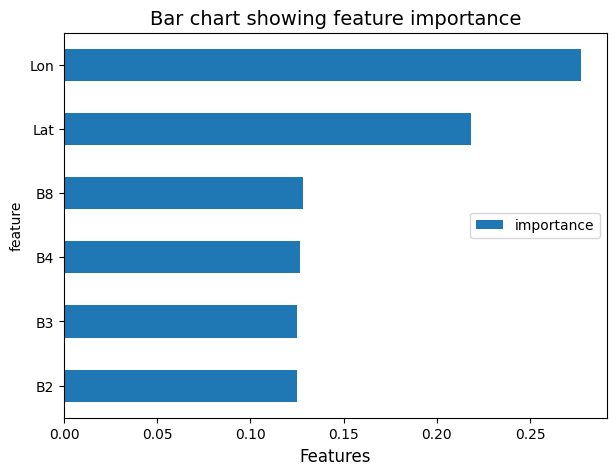

In [14]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (7, 5))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()

In [15]:
# Make prediction on the test set
test_df = test_data.drop(['ID'], axis = 1).fillna(0)
predictions = clf.predict(test_df)

# # Create a submission file
sub_file = pd.DataFrame({'ID': test_data.ID, 'Target': predictions})
sub_file.head()

,ID,Target
0,ID_9ZLHTVF6NSU7,0
1,ID_LNN7BFCVEZKA,0
2,ID_SOYSG7W04UH3,0
3,ID_EAP7EXXV8ZDE,0
4,ID_QPRX1TUQVGHU,0


In [16]:
# Create file and upload to Zindi for scoring
sub_file.to_csv('BaselineSubmission.csv', index = False)

# Enjoy the Challenge!!!